
Single de novo

In [4]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
#data <- read.table("/Users/hoang/Documents/GitHub/NewTestR/TestR/HBproject/extTADA/scripts/dataFromTADApaper2013.txt",
#                   header = TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
library("rstan")
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]

yLoF <- counts[, 1]
mutLoF <- data$mut.rate*mu.frac[1]
NN = length(y.case.lof)


Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


## Single de novo

In [2]:
library("rstan")

denovoBinomSingle <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ normal(10, 10);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
  + poisson_log(yLoFdn[ii], 2*Ndn*mutLoF[ii]);

ps[2] <- log(pi0)
  + poisson_log(yLoFdn[ii], 2*Ndn*mutLoF[ii]*gammaLoFdn);

increment_log_prob(log_sum_exp(ps));
}

}
"
yLoF <- counts[, 1]
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
yMis3 <- counts[, 4]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]
mutLoF <- data$mut.rate*mu.frac[1]
mutMis3 <- data$mut.rate*mu.frac[2]

#yLoF = yMis3; mutLoF <- mutMis3
mixdataSingle <- list(K = 2, 
                 yLoFdn = yLoF, mutLoF = mutLoF,
                 Ndn = N$dn)                 


Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [3]:
nSeed <- 233
mLoF <- stan_model(model_code = denovoBinomSingle)
fLoF <- vb(mLoF, seed = nSeed, data = mixdataSingle, iter = 100000, output_samples = 1000)
fLoF


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.00578 seconds
1000 iterations under these settings should take 5.78 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -2e+03             1.000            1.000
   200    -1561.0             0.546            1.000
   300    -1439.1             0.392            0.092
   400    -1436.3             0.295    

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 39cc504f40f6b3905ce40a109eaa7832.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.03 0.00  0.03  0.03  0.03  0.04  0.04
hyperGammaMeanLoFdn 26.36 5.56 17.43 22.32 25.76 29.61 38.95
hyperBetaLoFdn       1.01 0.01  0.98  1.00  1.01  1.02  1.03
gammaLoFdn          28.75 2.86 23.59 26.86 28.56 30.49 34.66
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Feb 10 16:18:31 2016.

In [4]:
testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = 2000, chains = 2, 
                control = list(adapt_delta = 0.9),
                pars = c('pi0','hyperGammaMeanLoFdn', 'hyperBetaLoFdn'))



SAMPLING FOR MODEL '39cc504f40f6b3905ce40a109eaa7832' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 61.0437 seconds (Warm-up)
#                54.0118 seconds (Sampling)
#                115.056 seconds (Total)
# 

SAMPLING FOR MODEL '39cc504f40f6b3905ce40a109eaa7832' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 

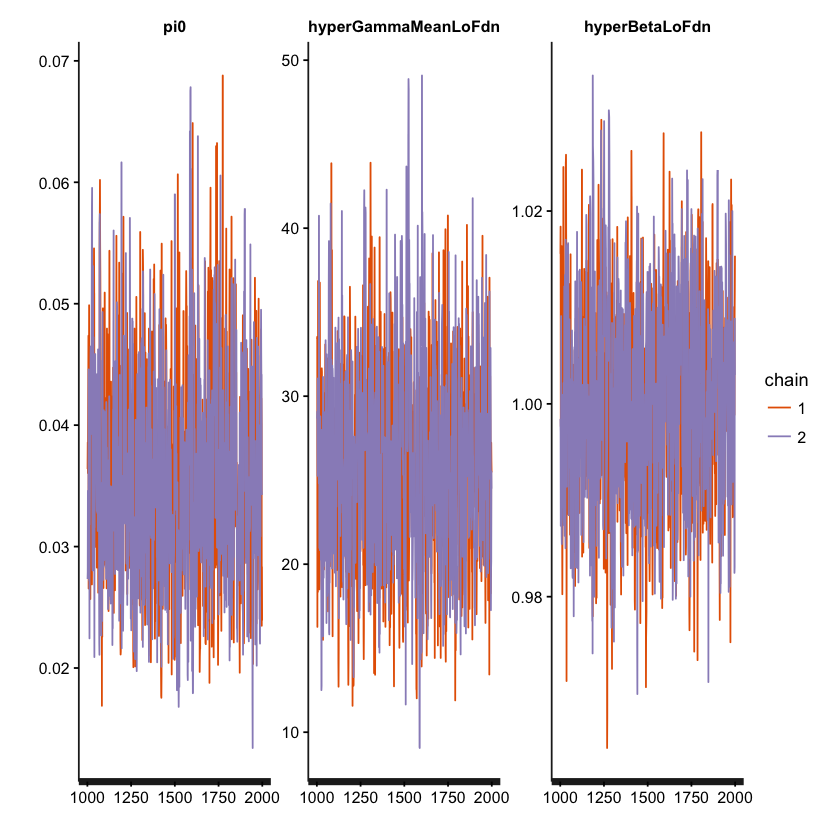

In [5]:
stan_trace(testFitSingle)


In [6]:
testFitSingle

Inference for Stan model: 39cc504f40f6b3905ce40a109eaa7832.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.04    0.00 0.01     0.02     0.03     0.03     0.04
hyperGammaMeanLoFdn    25.56    0.20 5.68    15.30    21.51    25.31    29.24
hyperBetaLoFdn          1.00    0.00 0.01     0.98     0.99     1.00     1.01
lp__                -1432.22    0.05 1.39 -1435.51 -1432.95 -1431.90 -1431.19
                       97.5% n_eff Rhat
pi0                     0.05   667    1
hyperGammaMeanLoFdn    36.87   772    1
hyperBetaLoFdn          1.02   842    1
lp__                -1430.46   687    1

Samples were drawn using NUTS(diag_e) at Wed Feb 10 16:22:26 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [7]:
nSeed1 <- 12345 #233
range(mutMis3)
mixdataSingleMis3 <- list(K = 2, 
                 yLoFdn = yMis3, mutLoF = mutMis3,
                 Ndn = N$dn)                 

mMis3 <- stan_model(model_code = denovoBinomSingle)
fMis3 <- vb(mMis3, seed = nSeed1, data = mixdataSingleMis3,
            iter = 100000, output_samples= 1000)
fMis3


[1] 8.857600e-09 3.985773e-04


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.006 seconds
1000 iterations under these settings should take 5.839 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1.000] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100    -3091.9             1.000            1.000
   200    -3086.6             0.501            1.000
   300    -3086.3             0.334            0.002   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posterior... COMPLETED.


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 39cc504f40f6b3905ce40a109eaa7832.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.08 0.01 0.06 0.07 0.08 0.09  0.10
hyperGammaMeanLoFdn 5.94 2.24 2.99 4.41 5.50 6.98 11.49
hyperBetaLoFdn      1.01 0.01 0.99 1.01 1.01 1.02  1.03
gammaLoFdn          4.43 0.46 3.63 4.11 4.41 4.73  5.33
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Feb 10 16:22:36 2016.

## LoF de novo + LoF case-control

In [8]:
denovoCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];


real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 5);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

hyperGammaMeanLoFcc ~ normal(15, 5);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) 
//+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii])
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) 
//+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn)
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"



In [9]:

mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


In [10]:
NSample <- 500000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC,
                    iter = NSample, output_samples= 1000)
fBothDenovoCC


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.019924 seconds
1000 iterations under these settings should take 19.924 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -2e+04             1.000            1.000
   200   -17619.8             0.567            1.000
   300   -17445.2             0.381            0.134
   400   -17432.4             0.286 

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 8e7a3182e1db08cdafad32cebf6b56ab.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.03 0.00  0.02  0.03  0.03  0.03  0.04
hyperGammaMeanLoFcc  1.80 0.57  1.19  1.43  1.66  1.99  3.22
hyperBetaLoFcc       4.03 0.01  4.00  4.02  4.03  4.03  4.05
gammaLoFcc           1.32 0.21  0.98  1.17  1.29  1.43  1.81
hyperGammaMeanLoFdn 20.98 2.91 15.72 18.97 20.73 22.84 27.08
hyperBetaLoFdn       1.02 0.01  1.00  1.01  1.02  1.03  1.05
gammaLoFdn          29.24 2.82 24.00 27.32 29.04 31.09 34.89
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Feb 10 16:23:50 2016.

In [11]:
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = 2000, chains = 2, 
#                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))



SAMPLING FOR MODEL '8e7a3182e1db08cdafad32cebf6b56ab' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 568.903 seconds (Warm-up)
#                222.978 seconds (Sampling)
#                791.881 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 1
                                                                                    count
Exception thrown at line 43: gamma_log: Shape parameter is inf, but must be finite!     5
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.



SAMPLING FOR MODEL '8e7a3182e1db08cdafad32cebf6b56ab' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 2, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 2, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 2, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 2, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 2, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 2, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 2, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 2, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 811.491 seconds (Warm-up)
#                192.849 seconds (Sampling)
#                1004.34 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 2
                                                                                    count
Exception thrown at line 43: gamma_log: Shape parameter is inf, but must be finite!     5
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.


In [12]:
testFitDenovoCC

Inference for Stan model: 8e7a3182e1db08cdafad32cebf6b56ab.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.03    0.00 0.01      0.02      0.03      0.03
hyperGammaMeanLoFdn     22.28    0.14 4.02     14.41     19.69     22.15
hyperGammaMeanLoFcc      1.86    0.02 0.61      1.04      1.38      1.76
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -17415.45    0.09 2.00 -17420.15 -17416.54 -17415.04
                          75%     97.5% n_eff Rhat
pi0                      0.04      0.05   457    1
hyperGammaMeanLoFdn     24.88     30.65   843    1
hyperGammaMeanLoFcc      2.20      3.29   864    1
hyperBetaLoFdn           1.01      1.02   807    1
hyperBetaLoFcc           4.01      4.02  1856    1
lp__ 

### Combine LoF case-control/de novo + Mis3 de novo

In [13]:
denovoCCBinom2 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

//int<lower=0> yCaseMis3[NN];
//int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;

real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

//real<lower=1> hyperGammaMeanMis3cc;
//real<lower=0.5> hyperBetaMis3cc;
//real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;

}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);

////
hyperGammaMeanMis3dn ~ normal(15, 10);
hyperBetaMis3dn ~ normal(1, 0.01);
//gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);

//hyperGammaMeanMis3cc ~ normal(15, 10);
//hyperBetaMis3cc ~ normal(4, 0.01);
//gammaMis3cc ~ gamma(hyperGammaMeanMis3cc*hyperBetaMis3cc, hyperBetaMis3cc);

gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);


for (ii in 1:NN){

ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]*gammaMis3dn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"

y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]

yLoF <- counts[, 1]
mutLoF <- data$mut.rate*mu.frac[1]
NN = length(y.case.lof)
yMis3 <- counts[, 4]
mutMis3 <- data$mut.rate*mu.frac[2]


mixdataDenovoCC2 <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [16]:
NSample <- 500000
mBothDenovoCC2 <- stan_model(model_code = denovoCCBinom2)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC2 <- vb(mBothDenovoCC2, seed = nSeed1,
                     data = mixdataDenovoCC2,
                     iter = NSample, output_samples= 1000)


ERROR: Error in stan_model(model_code = denovoCCBinom2): object 'denovoCCBinom2' not found


ERROR: Error in vb(mBothDenovoCC2, seed = nSeed1, data = mixdataDenovoCC2, iter = NSample, : error in evaluating the argument 'object' in selecting a method for function 'vb': Error: object 'mBothDenovoCC2' not found



In [17]:
fBothDenovoCC2


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 13d49c35f522390aa65f729458ac7cd7.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                      mean   sd  2.5%   25%   50%   75% 97.5%
pi0                   0.04 0.00  0.03  0.04  0.04  0.04  0.05
hyperGammaMeanLoFcc   1.45 0.43  1.07  1.20  1.33  1.57  2.62
hyperBetaLoFcc        3.91 0.01  3.90  3.91  3.91  3.91  3.92
gammaLoFcc            1.11 0.20  0.83  0.97  1.08  1.22  1.63
hyperGammaMeanLoFdn  22.52 6.18 12.57 17.99 21.76 26.27 35.94
hyperBetaLoFdn        1.02 0.01  0.99  1.01  1.02  1.02  1.04
gammaLoFdn           22.96 1.89 19.61 21.69 22.87 24.13 26.90
hyperGammaMeanMis3dn  7.36 2.94  3.57  5.35  6.78  8.56 14.64
hyperBetaMis3dn       1.00 0.01  0.98  0.99  1.00  1.01  1.02
gammaMis3dn           5.45 0.82  4.00  4.87  5.36  6.01  7.26
lp__                  0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Wed Feb 10 17:00:03 2016.

In [ ]:
testFitDenovoCC2 <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = 1000, chains = 2, cores = 2, 
                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperBetaLoFdn', 'hyperBetaLoFcc', 'hyperGammaMeanMis3dn'))


In [ ]:
testFitDenovoCC2

### Add a small epsilon to control q1 < q0

In [13]:
##############
##############
###Add epsilon

denovoCCBinomE <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

//int<lower=0> yCaseMis3[NN];
//int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;

real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=0,upper=1> eQMean;
real<lower=0> eQ;

//real<lower=1> hyperGammaMeanMis3cc;
//real<lower=0.5> hyperBetaMis3cc;
//real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;

}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);


eQ ~ gamma(eQMean, 1);

hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);

////
hyperGammaMeanMis3dn ~ normal(15, 10);
hyperBetaMis3dn ~ normal(1, 0.01);
//gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);

//hyperGammaMeanMis3cc ~ normal(15, 10);
//hyperBetaMis3cc ~ normal(4, 0.01);
//gammaMis3cc ~ gamma(hyperGammaMeanMis3cc*hyperBetaMis3cc, hyperBetaMis3cc);

gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);


for (ii in 1:NN){

ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]*gammaMis3dn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase*eQ/(gammaLoFcc*Ncase*eQ + Ncontrol));
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"

y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]

yLoF <- counts[, 1]
mutLoF <- data$mut.rate*mu.frac[1]
NN = length(y.case.lof)
yMis3 <- counts[, 4]
mutMis3 <- data$mut.rate*mu.frac[2]


mixdataDenovoCCE <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [17]:
NSample <- 500000
mBothDenovoCCE <- stan_model(model_code = denovoCCBinomE)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCCE <- vb(mBothDenovoCCE, seed = nSeed1,
                     data = mixdataDenovoCCE,
                     iter = NSample, output_samples= 1000)



This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.038575 seconds
1000 iterations under these settings should take 38.575 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -3e+09             1.000            1.000
   200  -1620477551878.9             0.999            1.000
   300  -4019042601515.3             0.865            0.998
   400  -137986321585.7             7.680            1.000
   500  -20047156681959.0             6.343            0.998
   600  -61396049804.9            59.539     

In [18]:
fBothDenovoCCE

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 43943d2d5aadeab833da6488e3d56a63.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                      mean   sd  2.5%   25%   50%   75% 97.5%
pi0                   0.04 0.00  0.03  0.03  0.04  0.04  0.05
hyperGammaMeanLoFcc  12.40 2.01  8.92 10.94 12.29 13.58 16.88
hyperBetaLoFcc        4.01 0.01  3.99  4.00  4.01  4.02  4.03
gammaLoFcc           11.66 1.25  9.39 10.78 11.64 12.49 14.12
hyperGammaMeanLoFdn  23.29 4.70 15.77 19.83 22.75 26.00 34.56
hyperBetaLoFdn        1.00 0.01  0.98  1.00  1.00  1.01  1.02
gammaLoFdn           24.38 2.23 19.91 22.91 24.34 25.75 28.76
eQMean                0.52 0.26  0.06  0.30  0.51  0.75  0.95
eQ                    0.52 0.26  0.06  0.30  0.51  0.75  0.95
hyperGammaMeanMis3dn  0.09 0.01  0.07  0.08  0.09  0.10  0.12
hyperBetaMis3dn       7.37 2.66  3.72  5.49  6.97  8.62 13.75
gammaMis3dn           0.99 0.01  0.97  0.98  0.99  1.00  1.02
lp__               

In [14]:
testFitDenovoCCE <- stan(model_code = denovoCCBinomE,
                         data = mixdataDenovoCCE, iter = 1000, chains = 2, cores = 2, 
                #         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperBetaLoFdn', 'hyperBetaLoFcc', 'hyperGammaMeanMis3dn',
                                 'eQMean', 'eQ'))


In [15]:
testFitDenovoCCE

Inference for Stan model: 43943d2d5aadeab833da6488e3d56a63.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.04    0.00 0.01      0.02      0.03      0.04
hyperGammaMeanLoFdn      23.00    0.23 5.36     13.54     19.02     22.83
hyperGammaMeanLoFcc      15.13    0.40 8.49      2.11      8.88     13.97
hyperBetaLoFdn            1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc            4.00    0.00 0.01      3.98      3.99      4.00
hyperGammaMeanMis3dn      7.31    0.09 2.48      3.21      5.55      7.10
eQMean                    0.51    0.01 0.26      0.07      0.30      0.50
eQ                        0.12    0.01 0.14      0.03      0.05      0.07
lp__                 -21313.79    0.16 2.81 -21320.20 -21315.45 -21313.40
                           75%     97.5% n_eff Rhat
pi0                       0.05  

In [ ]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
yLoF <- counts[, 1]
mutLoF <- data$mut.rate*mu.frac[1]

y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]
yMis3 <- counts[, 4]
mutMis3 <- data$mut.rate*mu.frac[2]


Ncase <- N$ca
Ncontrol <- N$cn
pH0 <- Ncase/(Ncase + Ncontrol)

bfcc <- function(ycase, ytotal, Ncase, Ncontrol,
                 lower.gamma = 1, upper.gamma = 50,
                 hyperGammaMeanCC = 1.94, hyperBetaCC = 1.98, tolERR = 10^-6){
  bfH0 <- dbinom(ycase, ytotal, prob = pH0)
  
  
  bfH1 <- apply(cbind(ycase, ytotal), 1, function(x){
    f1 <- function(gamma0)
      dbinom(x[1], x[2], gamma0*Ncase/(gamma0*Ncase + Ncontrol))*dgamma(gamma0, 
                                                                        shape = hyperGammaMeanCC*hyperBetaCC,
                                                                        rate = hyperBetaCC)
    #    print(x)
    return(integrate(f1, lower = lower.gamma, upper = upper.gamma, rel.tol = tolERR)$value)
  })
  return(bfH1/bfH0)
  
}
BFccLoF <- bfcc(ycase = y.case.lof, ytotal = y.case.lof + y.control.lof, Ncase = N$ca, Ncontrol = N$cn,
                hyperGammaMeanCC = 1.64, hyperBetaCC = 4.15)

range(BFccLoF)
yTemp <- y.case.mis3 + y.control.mis3

BFccMis3 <- bfcc(ycase = y.case.mis3, ytotal = y.case.mis3 + y.control.mis3, Ncase = N$ca, Ncontrol = N$cn,
                 hyperGammaMeanCC = 1.47, hyperBetaCC = 4.05)
range(BFccMis3)

source("TADA/TADA.R")

BFdnLoF <- bayes.factor.denovo(x = yLoF, N = N$dn, mu = mutLoF, gamma.mean = 22.96, beta = 1)
BFdnMis3 <- bayes.factor.denovo(x = yMis3, N = N$dn, mu = mutMis3, gamma.mean = 8.97, beta = 1)

BFall <- BFccLoF*BFdnLoF*BFdnMis3

data$BF <- BFall
data <- data[order(-data$BF),]
pi0 <- 1 - 0.04
data$qvalue <- Bayesian.FDR(data$BF, pi0)$FDR

data1 <- (data[data$qvalue < 0.1, ])
dim(data1)
head(data1, 25)
